# Twitter Election Text Analysis

Hi! This is Election'16 Analysis done from 18000+ tweets streamed from twitter API.

In this Python notebook we:
- See what hashtags related to Elections are trending.
- See most common words popping up in Election tweets. And form a wordcloud for each candidate!
- Compare Original/Retweets for each candidate
- See which candidate has most Favorites
- Plot location of tweets
 
Lets begin! 

In [62]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from pymongo import MongoClient
import matplotlib.pyplot as plt
import tweepy
import json

# Variables that contains the user credentials to access Twitter API 
# Removed after usage 
consumer_key = 'XXX'
consumer_secret = 'XXX'
access_token = 'XXX'
access_secret = 'XXX'

 

In [63]:
# Accessing MongoDB
client = MongoClient('localhost', 27017)
db = client.finaldb
collection = db.finaldb

In [ ]:
# Using listener to Stream tweets into MongoDB Collection

class StdOutListener(StreamListener):
    
    def on_connect(self):
        print("You're connected to the streaming server.")
 
    def on_error(self, status_code):
        print('Error: ' + repr(status_code))
        return False
 
    def on_data(self, data):
        client = MongoClient('localhost', 27017)
        #print(data);
        # Use finaldb database
        db = client.finaldb
 
        # Decode JSON
        datajson = json.loads(data)
        
        # Store tweet info into the final collection.
        db.finaldb.insert_one(datajson)
 


 
if __name__ == '__main__':
    # This handles Twitter authetication and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    stream = Stream(auth, l)

#This line filter Twitter Streams to capture data by the keywords
stream.filter(track=["USelections", "US elections", "USA Elections", "#USElection","#USelections", "#USelection" "#USElections", "USelection","US2016","USA2016", "USAElection", "USelection", "USAelections", "uselection", "uselections", "usaelection", "usaelections"])

### Alright! We have 18000+ tweets. Let's get started!
First let's look at one tweet and see its format.

In [177]:
collection.find_one()

{'_id': ObjectId('581d90046329b717f2be9984'),
 'contributors': None,
 'coordinates': None,
 'created_at': 'Sat Nov 05 07:53:17 +0000 2016',
 'entities': {'hashtags': [{'indices': [21, 37], 'text': 'wednesdaywisdom'},
   {'indices': [38, 49], 'text': 'USElection'}],
  'media': [{'display_url': 'pic.twitter.com/LA8Ztt5sWw',
    'expanded_url': 'https://twitter.com/GoswellRdCoffee/status/793751743767216128/photo/1',
    'id': 793751531707400192,
    'id_str': '793751531707400192',
    'indices': [50, 73],
    'media_url': 'http://pbs.twimg.com/tweet_video_thumb/CwP40AdXgAAPGar.jpg',
    'media_url_https': 'https://pbs.twimg.com/tweet_video_thumb/CwP40AdXgAAPGar.jpg',
    'sizes': {'large': {'h': 720, 'resize': 'fit', 'w': 720},
     'medium': {'h': 600, 'resize': 'fit', 'w': 600},
     'small': {'h': 340, 'resize': 'fit', 'w': 340},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'source_status_id': 793751743767216128,
    'source_status_id_str': '793751743767216128',
    'sour

## Cleaning Data
Let's remove duplicates and tweets that are not in English.

In [46]:
#Delete Duplicate ids
idss = []
flag = 0;
for d in collection.find():
    try:
        if d['id'] not in idss:
            idss.append(d['id'])
        elif d['id'] in idss:
            collection.delete_one({'id': d['id']})
    except:
        pass

In [ ]:
#Delete Duplicate text
text= []
flag = 0;
for d in collection.find():
    try:
        if d['text'] not in text:
            text.append(d['text'])
        elif d['text'] in text:
            #print(d['text'])
            collection.delete_one({'id': d['id']})
    except:
        pass

In [53]:
# Delete Tweets not in english
for d in collection.find():
    try:
        if d['lang'] != "en":
            collection.delete_one({'id': d['id']})
    except:
        pass

In [19]:
collection.count()

18482

In [10]:
# Write all tweets text into file (2.1 mb)

f = open("result.txt", "a");

for d in collection.find():
    try:
        if d['text']:
            myString = str(d['text'])
            f.write(myString)
    except:
        pass

f.close()

### MOST USED HASHTAGS

In [33]:
hashtag = []

for d in collection.find():
    try:
        if(d['entities']['hashtags']):  
            for i in range(len(d['entities']['hashtags'])):
                hashtag.append(d['entities']['hashtags'][i]['text'])
    except:
        pass
    

In [51]:
from collections import Counter
count = Counter(hashtag)
words = count.most_common(15)
words


[('USElection', 259),
 ('Trump', 216),
 ('Hillary', 150),
 ('Clinton', 144),
 ('MAGA', 129),
 ('ImWithHer', 108),
 ('SpiritCooking', 101),
 ('RememberWhenTrump', 92),
 ('NeverTrump', 68),
 ('PodestaEmails31', 66),
 ('USElections2016', 64),
 ('HillaryClinton', 56),
 ('DonaldTrump', 56),
 ('TrumpPence16', 46),
 ('USelection', 42)]

### Interesting! Let's dig deeper and find explanations to these hashtags other than the obvious ones.

MAGA : Ivanka Trump Bought Kellyanne Conway (Trump's Media Manager) a Classy 'MAGA' Bracelet.

SpiritCooking : Hillary Tied to Bizarre Occult "Spirit Cooking" Ritual

PoestaEmails31: WikiLeaks on Twitter: "RELEASE: The Podesta Emails Part 31  



### Lets get a visual of this:

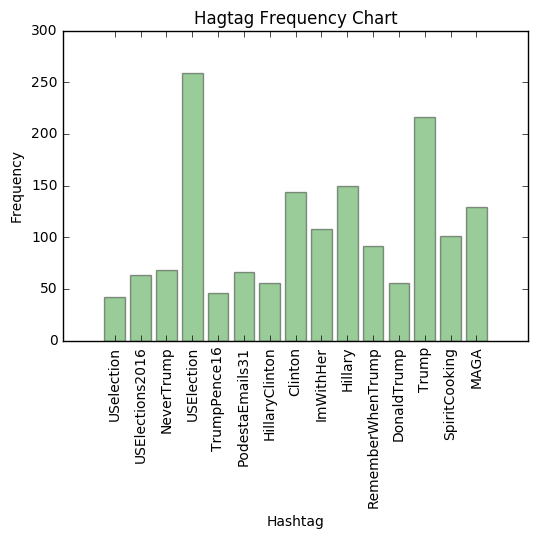

In [54]:
wordsdict = {}
for w in words:
    wordsdict[w[0]]=w[1]

width = 0.7
plt.bar(range(len(wordsdict)), wordsdict.values(), align='center', color='green', alpha=0.4)
plt.xticks(range(len(wordsdict)), wordsdict.keys())
plt.xticks(rotation=90)
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.title('Hagtag Frequency Chart')
plt.show()

## Analysing Word frequencies among all the tweets.

In [12]:
from nltk.corpus import stopwords
import string

In [13]:
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt','RT','via', '...','The','I','This','...','To','Is','For']

In [11]:
#import regex
import re

#start process_tweet
def processTweet(tweet):
    # process the tweets

    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #trim
    tweet = tweet.strip('\'"')
    return tweet
#end

 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 


### Now Let's find 50 most commonly used words in our whole corpus of 18000+ tweets.

In [57]:
count_all = Counter()
for d in collection.find():
    try:
        terms_all = [term for term in preprocess(d['text']) if term not in stop]
        # Update the counter
        count_all.update(terms_all)
    except:
        pass
    # Print the first 5 most frequent words
common = count_all.most_common(50)
common


[('Hillary', 6846),
 ('Trump', 6451),
 ('Clinton', 6422),
 ('…', 6115),
 ('Donald', 5728),
 ('’', 1737),
 ('amp', 1035),
 ('A', 691),
 ('vote', 650),
 ('US', 630),
 ("Clinton's", 566),
 ('Vote', 522),
 ("Trump's", 512),
 ('@YouTube', 498),
 ('Jay', 482),
 ('FBI', 468),
 ('Z', 435),
 ('https', 424),
 ('like', 419),
 ('America', 419),
 ('Bill', 412),
 ('@realDonaldTrump', 405),
 ('In', 400),
 ('Obama', 394),
 ('‘', 393),
 ('#Trump', 391),
 ('Rally', 390),
 ('campaign', 388),
 ('people', 372),
 ('What', 371),
 ('He', 370),
 ('election', 368),
 ('How', 352),
 ('President', 349),
 ('TRUMP', 345),
 ('If', 334),
 ('HILLARY', 317),
 ('would', 315),
 ('#USElection', 309),
 ('Email', 304),
 ('1', 300),
 ('😂', 294),
 ('Why', 293),
 ('@HillaryClinton', 291),
 ('New', 288),
 ('president', 288),
 ('get', 284),
 ('And', 281),
 ('CLINTON', 281),
 ('You', 279)]

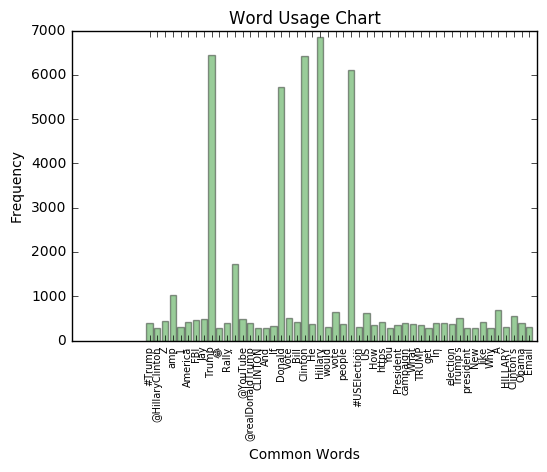

In [73]:
wordsdict = {}
for w in common:
    wordsdict[w[0]]=w[1]


plt.bar(range(len(wordsdict)), wordsdict.values(), align='center', color='green', alpha=0.4)
plt.xticks(range(len(wordsdict)), wordsdict.keys())
label_size = 6
plt.rcParams['xtick.labelsize'] = label_size 
plt.xticks(rotation=90)
plt.xlabel('Common Words')
plt.ylabel('Frequency')
plt.title('Word Usage Chart')
plt.show()

### WORDCLOUD

Wohoo! 

In [4]:
import PIL as pillow
from PIL import Image
from wordcloud import WordCloud



In [9]:
all_text =''
for d in collection.find():
    try:
        if d['text']:
            all_text = all_text + d['text'] + " "
    except:
        pass

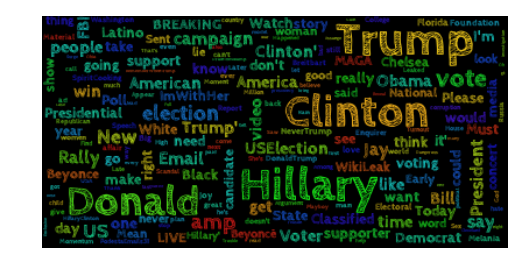

In [93]:
wordcloud1 = WordCloud().generate(all_text)

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in all_text.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud1 = WordCloud(max_font_size=40, relative_scaling=.5, stopwords=stop, font_path='CabinSketch-Bold.ttf').generate(no_urls_no_tags)
plt.figure()
plt.imshow(wordcloud1)
plt.axis("off")
plt.show()

In [5]:
Hillary = ''

for d in collection.find():
    try:
        if 'Hillary' in d['text'] or 'Clinton' in d['text']:
            Hillary = Hillary + d['text'] + " "
    except:
        pass

In [6]:
len(Hillary)

1013631

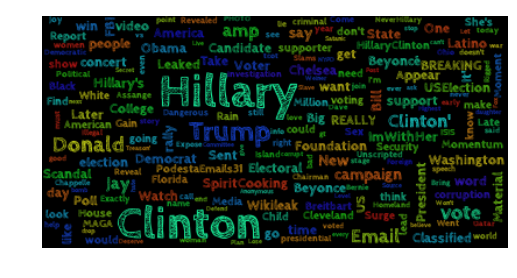

In [17]:
wordcloud_Hillary = WordCloud().generate(Hillary)

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in Hillary.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud_Hillary = WordCloud(max_font_size=40, relative_scaling=.5, stopwords=stop, font_path='CabinSketch-Bold.ttf').generate(no_urls_no_tags)
plt.figure()
plt.imshow(wordcloud_Hillary)
plt.axis("off")
plt.show()

In [7]:
Trump = ''

for d in collection.find():
    try:
        if 'Donald' in d['text'] or 'Trump' in d['text']:
            Trump = Trump + d['text'] + " "
    except:
        pass

In [8]:
len(Trump)

953888

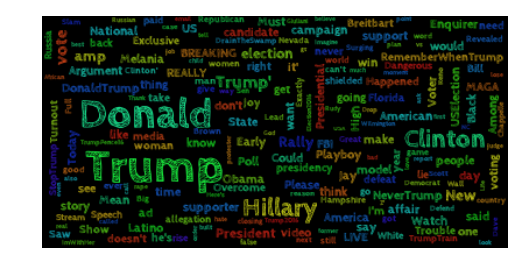

In [18]:
wordcloud_Trump = WordCloud().generate(Trump)

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in Trump.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud_Trump = WordCloud(max_font_size=40, relative_scaling=.5, stopwords=stop, font_path='CabinSketch-Bold.ttf').generate(no_urls_no_tags)
plt.figure()
plt.imshow(wordcloud_Trump)
plt.axis("off")
plt.show()

## Compare Retweets/ No. of Favourites for Original tweets

In [20]:
# Creating DB with all Hillary tweets
for d in collection.find():
    try:
        if 'Hillary' in d['text'] or 'Clinton' in d['text']:
            db.Hillary.insert_one(d)
    except:
        pass

In [21]:
db.Hillary.count()

8332

In [22]:
# Creating DB with all Trump tweets
for d in collection.find():
    try:
        if 'Donald' in d['text'] or 'Trump' in d['text']:
            db.Trump.insert_one(d)
    except:
        pass

In [23]:
db.Trump.count()

7974

## Original vs Retweets of 18000+ tweets

In [36]:
Orig = 0
RT = 0
Fav_count = 0

for d in collection.find():
    try:
        if 'RT' in d['text']:
            RT += 1
        else:
            Orig += 1
            Fav_count += d['favorite_count']
    except:
        pass
print('Original Posts: ', Orig)
print('Retweets: ', RT)
print('Favorite Count: ', Fav_count)

Original Posts:  10041
Retweets:  8416
Favorite Count:  40


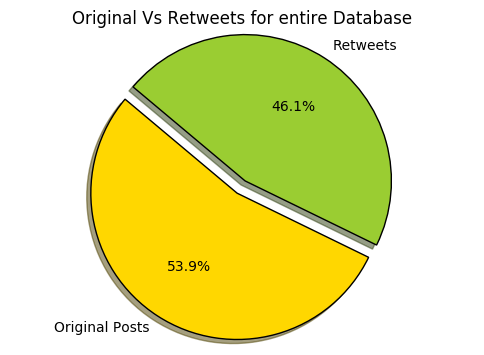

In [53]:
import matplotlib.pyplot as plt
labels = 'Original Posts', 'Retweets'
sizes = Orig, RT
colors = ['gold', 'yellowgreen']
explode = (0.1, 0)  
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.title('Original Vs Retweets for entire Database')
plt.show()

In [45]:
Hill_Orig = 0
Hill_RT = 0
Hill_Fav_count = 0

for d in db.Hillary.find():
    try:
        if 'RT' in d['text']:
            Hill_RT += 1
        else:
            Hill_Orig += 1
            Hill_Fav_count += d['favorite_count']
    except:
        pass
print('Original Posts: ', Hill_Orig)
print('Retweets: ', Hill_RT)
print('Favorite Count: ', Hill_Fav_count)

Original Posts:  4395
Retweets:  3937
Favorite Count:  14


In [46]:
Trump_Orig = 0
Trump_RT = 0
Trump_Fav_count = 0

for d in db.Trump.find():
    try:
        if 'RT' in d['text']:
            Trump_RT += 1
        else:
            Trump_Orig += 1
            Trump_Fav_count += d['favorite_count']
    except:
        pass
print('Original Posts: ', Trump_Orig)
print('Retweets: ', Trump_RT)
print('Favorite Count: ', Trump_Fav_count)

Original Posts:  4125
Retweets:  3849
Favorite Count:  14


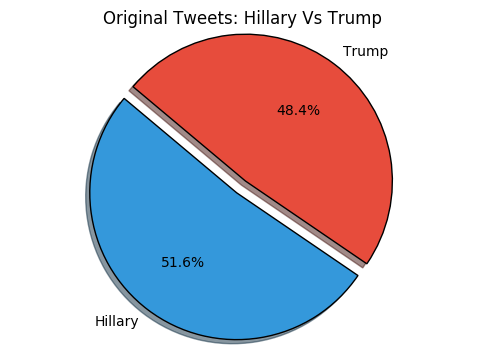

In [54]:
labels = 'Hillary', 'Trump'
sizes = Hill_Orig, Trump_Orig
colors = ['#3498db', '#e74c3c']
explode = (0.1, 0)  

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.title('Original Tweets: Hillary Vs Trump')
plt.show()

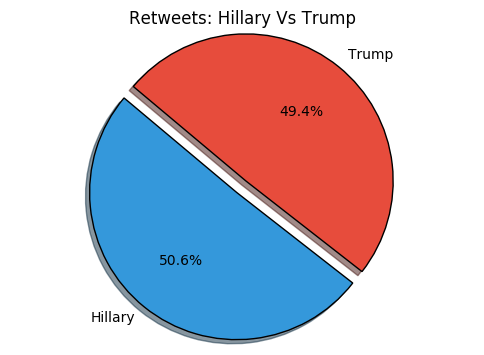

In [55]:
labels = 'Hillary', 'Trump'
sizes = Hill_RT, Trump_RT
colors = ['#3498db', '#e74c3c']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.title('Retweets: Hillary Vs Trump')
plt.show()

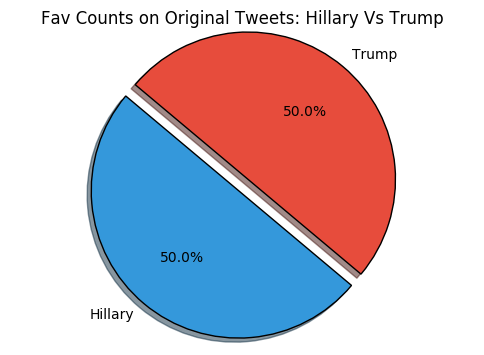

In [56]:
labels = 'Hillary', 'Trump'
sizes = Hill_Fav_count, Trump_Fav_count
colors = ['#3498db', '#e74c3c']
explode = (0.1, 0)  

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.title('Fav Counts on Original Tweets: Hillary Vs Trump')
plt.show()

## Geoplot

In [64]:
##Getting coordinates of geo-enabled tweets from database

coordinates = []

for d in collection.find():
    try:
        if d['coordinates'] != None:
            coordinates.append(tuple(d['geo']['coordinates']))
    except:
        pass

In [65]:
## Incase map is not visible please check tweets_heatmap1 in repository.

import gmaps
import gmaps.datasets
gmaps.configure(api_key="XXX") # Google API key


m = gmaps.Map()

heatmap_layer = gmaps.Heatmap(data=coordinates)
m.add_layer(heatmap_layer)
m

In [ ]:
# Optional

# Since Streaming api does not return enough geo-enabled tweets 
# To get coordinates of 100 major Cities in USA 
# Using search API to filter geo-enabled tweets

import json
with open('cities.json') as json_data:
    d = json.load(json_data)
    
for i in range(len(d)):
        # Get coordinates of 1000 major cities 
        string = str(d[i]['latitude'])+ ',' + str(d[i]['longitude']) + ',' + '1mi'
        
        # For 1st 16 cities in cities.json 
        tweets = api.search(q=["Hillary" or "Trump"], count= 1000, geocode=string)
        for tweet in tweets:
            if(tweet.coordinates!=None): 
                twt = tweet._json
                # change database name
                db.coordinates.insert_one(twt)
        
       

In [69]:
coordinates2 = []

for d in db.coordinates.find():
    try:
        if d['coordinates'] != None:
            coordinates2.append(tuple(d['geo']['coordinates']))
    except:
        pass

In [70]:
## Incase map is not visible please check tweets_heatmap2 in repository.
# Plotting for 16 cities

m = gmaps.Map()

heatmap_layer = gmaps.Heatmap(data=coordinates2)
m.add_layer(heatmap_layer)
m

## That's all folks, Thank you!